# Interactive two population network example

To run this interactive Jupyter Notebook, please click on the rocket icon 🚀 in the top panel. For more information, please see {ref}`how to use this documentation <userdocs:usage:jupyterbooks>`. Please uncomment the line below if you use the Google Colab. (It does not include these packages by default).

In [1]:
#%pip install pyneuroml neuromllite NEURON

In [2]:
#!/usr/bin/env python3
"""
Create a simple network with two populations.
"""

from neuroml import NeuroMLDocument
from neuroml import Izhikevich2007Cell
from neuroml import Network
from neuroml import ExpOneSynapse
from neuroml import Population
from neuroml import Projection
from neuroml import PulseGenerator
from neuroml import ExplicitInput
from neuroml import Connection
from neuroml import Property
import neuroml.writers as writers
import random
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation
import numpy as np

## Declaring the NeuroML model

### Create a NeuroML document

In [3]:
nml_doc = NeuroMLDocument(id="IzNet")

### Declare the Izhikevich cell and add it to the model document

In [4]:
iz0 = Izhikevich2007Cell(
    id="iz2007RS0", v0="-60mV", C="100pF", k="0.7nS_per_mV", vr="-60mV",
    vt="-40mV", vpeak="35mV", a="0.03per_ms", b="-2nS", c="-50.0mV", d="100pA")
nml_doc.add(iz0)
# under the hood: nml_doc.izhikevich2007_cells.append(iz0)

### Declare the Synapse and add it to the model document

In [5]:
syn0 = ExpOneSynapse(id="syn0", gbase="65nS", erev="0mV", tau_decay="3ms")
nml_doc.add(syn0)
# under the hood: nml_doc.exp_one_synapses.append(syn0)

### Declare a Network and add it to the model document

In [6]:
net = Network(id="IzNet")
nml_doc.add(net)
# under the hood: nml_doc.networks.append(net)

### Create two populations

In [7]:
size0 = 5
pop0 = Population(id="IzPop0", component=iz0.id, size=size0)
net.add(pop0)
# net.populations.append(pop0)

size1 = 5
pop1 = Population(id="IzPop1", component=iz0.id, size=size1)
net.add(pop1)
# net.populations.append(pop1)
net.info(True)

Valid members for Network are:
* type (class: networkTypes)
	* Contents: None

* temperature (class: Nml2Quantity_temperature)
	* Contents: None

* spaces (class: Space)
	* Contents: []

* regions (class: Region)
	* Contents: []

* extracellular_properties (class: ExtracellularPropertiesLocal)
	* Contents: []

* populations (class: Population)
	* Contents: [<neuroml.nml.nml.Population object at 0x7f2c1c68ca00>, <neuroml.nml.nml.Population object at 0x7f2c1c68da20>]

* cell_sets (class: CellSet)
	* Contents: []

* synaptic_connections (class: SynapticConnection)
	* Contents: []

* projections (class: Projection)
	* Contents: []

* electrical_projections (class: ElectricalProjection)
	* Contents: []

* continuous_projections (class: ContinuousProjection)
	* Contents: []

* explicit_inputs (class: ExplicitInput)
	* Contents: []

* input_lists (class: InputList)
	* Contents: []

Please see the NeuroML standard schema documentation at https://docs.neuroml.org/Userdocs/NeuroMLv2.html for mor

'Valid members for Network are:\n* type (class: networkTypes)\n\t* Contents: None\n\n* temperature (class: Nml2Quantity_temperature)\n\t* Contents: None\n\n* spaces (class: Space)\n\t* Contents: []\n\n* regions (class: Region)\n\t* Contents: []\n\n* extracellular_properties (class: ExtracellularPropertiesLocal)\n\t* Contents: []\n\n* populations (class: Population)\n\t* Contents: [<neuroml.nml.nml.Population object at 0x7f2c1c68ca00>, <neuroml.nml.nml.Population object at 0x7f2c1c68da20>]\n\n* cell_sets (class: CellSet)\n\t* Contents: []\n\n* synaptic_connections (class: SynapticConnection)\n\t* Contents: []\n\n* projections (class: Projection)\n\t* Contents: []\n\n* electrical_projections (class: ElectricalProjection)\n\t* Contents: []\n\n* continuous_projections (class: ContinuousProjection)\n\t* Contents: []\n\n* explicit_inputs (class: ExplicitInput)\n\t* Contents: []\n\n* input_lists (class: InputList)\n\t* Contents: []\n\nPlease see the NeuroML standard schema documentation at ht

### Declare projections

In [17]:
help(Projection)
net.id

Help on class Projection in module neuroml.nml.nml:

class Projection(BaseProjection)
 |  Projection(neuro_lex_id=None, id=None, presynaptic_population=None, postsynaptic_population=None, synapse=None, connections=None, connection_wds=None, gds_collector_=None, **kwargs_)
 |  
 |  Projection -- Projection from one population, **presynapticPopulation**  to another, **postsynapticPopulation,**  through **synapse.**  Contains lists of  **connection**  or  **connectionWD**  elements.
 |  
 |  Method resolution order:
 |      Projection
 |      BaseProjection
 |      Base
 |      BaseWithoutId
 |      GeneratedsSuper
 |      GeneratedsSuperSuper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __init__(self, neuro_lex_id=None, id=None, presynaptic_population=None, postsynaptic_population=None, synapse=None, connections=None, connection_wds=None, gds_collector_=None, **kwargs_)
 |      Initialize self.  See help(type(self))

'IzNet'

In [8]:
proj = Projection(id='proj', presynaptic_population=pop0.id,
                  postsynaptic_population=pop1.id, synapse=syn0.id)
net.add(proj)
# net.projections.append(proj)

### Add the projections between populations and the external inputs

In [9]:
random.seed(123)
prob_connection = 0.8
count = 0
for pre in range(0, size0):
    pg = PulseGenerator(
        id="pg_%i" % pre, delay="0ms", duration="10000ms",
        amplitude="%f nA" % (0.1 + 0.1 * random.random())
    )
    nml_doc.add(pg)
    # nml_doc.pulse_generators.append(pg)

    exp_input = ExplicitInput(target="%s[%i]" % (pop0.id, pre), input=pg.id)
    net.add(exp_input)
    # net.explicit_inputs.append(exp_input)

    for post in range(0, size1):
        if random.random() <= prob_connection:
            syn = Connection(id=count,
                             pre_cell_id="../%s[%i]" % (pop0.id, pre),
                             synapse=syn0.id,
                             post_cell_id="../%s[%i]" % (pop1.id, post))
            proj.add(syn)
            # proj.connections.append(syn)
            count += 1

### Write the NeuroML model to a NeuroML file and validate it

In [10]:
nml_file = 'izhikevich2007_network.nml'
writers.NeuroMLWriter.write(nml_doc, nml_file)

print("Written network file to: " + nml_file)
pynml.validate_neuroml2(nml_file)

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/usr/share/java/jNeuroML-0.11.1.jar" -validate "izhikevich2007_network.nml" ) in directory: .


Written network file to: izhikevich2007_network.nml


pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Validating: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/izhikevich2007_network.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  


True

## Simulating the model
### Create a simulation instance of the model

In [11]:
simulation_id = "example_izhikevich2007network_sim"
simulation = LEMSSimulation(sim_id=simulation_id,
                            duration=1000, dt=0.1, simulation_seed=123)
simulation.assign_simulation_target(net.id)
simulation.include_neuroml2_file(nml_file)

pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/izhikevich2007_network.nml


<?xml version="1.0" ?>
<neuroml xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" id="IzNet">
    <expOneSynapse id="syn0" gbase="65nS" erev="0mV" tauDecay="3ms"/>
    <izhikevich2007Cell id="iz2007RS0" C="100pF" v0="-60mV" k="0.7nS_per_mV" vr="-60mV" vt="-40mV" vpeak="35mV" a="0.03per_ms" b="-2nS" c="-50.0mV" d="100pA"/>
    <pulseGenerator id="pg_0" delay="0ms" duration="10000ms" amplitude="0.105236 nA"/>
    <pulseGenerator id="pg_1" delay="0ms" duration="10000ms" amplitude="0.153620 nA"/>
    <pulseGenerator id="pg_2" delay="0ms" duration="10000ms" amplitude="0.124516 nA"/>
    <pulseGenerator id="pg_3" delay="0ms" duration="10000ms" amplitude="0.131546 nA"/>
    <pulseGenerator id="pg_4" delay="0ms" duration="10000ms" amplitude="0.102124 nA"/>
    <network id="IzNet">
        <population id="IzPop0" component="iz2007RS0" size="5"/>
        <population id="IzPop1" component="iz2007RS0" size="5"/>
        <projection id="proj" presynap

### Define the output file to store spikes

In [12]:
simulation.create_event_output_file(
    "pop0", "%s.0.spikes.dat" % simulation_id, format='ID_TIME'
)
for pre in range(0, size0):
    simulation.add_selection_to_event_output_file(
        "pop0", pre, 'IzPop0[{}]'.format(pre), 'spike')

simulation.create_event_output_file(
    "pop1", "%s.1.spikes.dat" % simulation_id, format='ID_TIME'
)
for pre in range(0, size1):
    simulation.add_selection_to_event_output_file(
        "pop1", pre, 'IzPop1[{}]'.format(pre), 'spike')

## Save the simulation to a file

In [13]:
lems_simulation_file = simulation.save_to_file()

## Run the simulation using jNeuroML

In [14]:
pynml.run_lems_with_jneuroml(
    lems_simulation_file, max_memory="2G", nogui=True, plot=False
)

pyNeuroML >>> INFO - Loading LEMS file: LEMS_example_izhikevich2007network_sim.xml and running with jNeuroML
pyNeuroML >>> INFO - Executing: (java -Xmx2G  -Djava.awt.headless=true -jar  "/usr/share/java/jNeuroML-0.11.1.jar"  "LEMS_example_izhikevich2007network_sim.xml"  -nogui -I '') in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Loading: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/LEMS_example_izhikevich2007network_sim.xml with jLEMS, NO GUI mode...
  jNeuroML >>  INFO Jul 22,2022 17:36  (INFO) Loading LEMS file from: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/LEMS_example_izhikevich2007network_sim.xml
  jNeuroML >>  INFO Jul 22,2022 17:36  (INFO) Reading from: /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/LEMS_example_izhikevich2007network_sim.xml
  jNeur

True

## Plot the recorded data

pyNeuroML >>> INFO - Generating plot: Spike times
/usr/lib/python3.10/site-packages/pyneuroml/pynml.py:2612: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(
pyNeuroML >>> INFO - Saving image to /home/asinha/Documents/02_Code/00_mine/2020-OSB/NeuroML-Documentation/source/Userdocs/NML2_examples/example_izhikevich2007network_sim-spikes.png of plot: Spike times
pyNeuroML >>> INFO - Saved image to example_izhikevich2007network_sim-spikes.png of plot: Spike times


<AxesSubplot:xlabel='time (s)', ylabel='cell ID'>

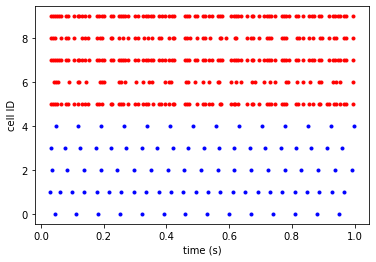

In [15]:
# Load the data from the file and plot the spike times
# using the pynml generate_plot utility function.
data_array_0 = np.loadtxt("%s.0.spikes.dat" % simulation_id)
data_array_1 = np.loadtxt("%s.1.spikes.dat" % simulation_id)
times_0 = data_array_0[:,1]
times_1 = data_array_1[:,1]
ids_0 = data_array_0[:,0]
ids_1 = [id+size0 for id in data_array_1[:,0]]
pynml.generate_plot(
    [times_0,times_1], [ids_0,ids_1],
    "Spike times", show_plot_already=False,
    save_figure_to="%s-spikes.png" % simulation_id,
    xaxis="time (s)", yaxis="cell ID",
    colors=['b','r'],
    linewidths=['0','0'], markers=['.','.'],
)